# Food Vision

We have to get atleast an accuracy of 77.4% on test dataset to achieve better results than - https://arxiv.org/abs/1606.05675 paper

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-15f6cfbf-9034-ea7d-08d5-18f6de54ec7a)


## Use TensorFlow Datasets to download data

In [2]:
import tensorflow_datasets as tfds

In [3]:
# Check if food101 exists in the list of datasets
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [5]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=False,
                                             as_supervised=True, #data gets returned in tuple format (data,label)
                                             with_info=True)

## Exploring the food101 data from TensorFlow Datasets

To become one with our data we need to find out:
* Class Names
* Shape of our input data (image tensors)
* Datatype of input data
* How the label looks like? (Are they one hot encoded or they are label encoded)
* Do the labels match up with the class names?

In [6]:
# Features of our dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Check out class names of our dataset
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Check the number of class names
len(class_names)

101

In [9]:
# Take one sample of our train data
train_data_one_sample = train_data.take(1)

In [10]:
# What does our 1 sample look like?
train_data_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Samples are in format image tensor and label

In [11]:
# Output info about our training sample
for image, label in train_data_one_sample:
  print(f"""
  Image Shape : {image.shape},
  Image Dtype : {image.dtype},
  Target Class from food101 (tensor form) : {label},
  Class Name (str from) : {class_names[label.numpy()]} 
  """)


  Image Shape : (512, 512, 3),
  Image Dtype : <dtype: 'uint8'>,
  Target Class from food101 (tensor form) : 56,
  Class Name (str from) : huevos_rancheros 
  


In [12]:
# What does our image tensor looks like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

### Plot an image from tensorflow datasets

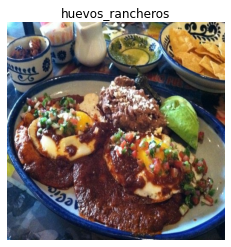

In [13]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Our data is currently:

* In uint8 data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In float32 data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized

In [14]:
import tensorflow as tf
def preprocess_image(image,label,img_shape=224):
  """
  Converts image dtype from uint8 to float32 and reshapes images to (img_shape,img_shape,color_channels)
  """
  image = tf.image.resize(image, [img_shape,img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_img, label) tuple

In [15]:
# Preprocess a single image and check ouputs
preprocessed_image = preprocess_image(image,label)[0] #index 0 to get only 1st part of tuple that is the image
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_image[:2]}...,\nShape: {preprocessed_image.shape},\nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and prepare dataset

We will now make our data input pipeline run very fast

In [16]:
# Map the preprocess function to our training data and also parallelize it
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map the preprocess function to our testing data and also parallelize it
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

In [18]:
# ModelCheckpoint Callback
checkpoint_path = "model_checkpoint/feature-extract-model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [19]:
# TensorBoard Callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Setup Mixed Precision Training

Mixed Precision utilizes a combination of float32 and float16 to speed up model performance if the gpu scores is > 7.0

In [20]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [21]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Create a feature extraction model

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [24]:
# Checking layers which are trainable
for layers in model.layers:
  print(layers.name, layers.trainable, layers.dtype, layers.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [25]:
# Checking layers trainable in EfficientNetB0
for layers in model.layers[1].layers:
  print(layers.name, layers.trainable, layers.dtype, layers.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [26]:
# Fit the model
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback("training_logs","feature_extraction_model_final"),model_checkpoint])

Saving TensorBoard log files to: training_logs/feature_extraction_model_final/20211029-102149


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/3
2368/2368 [==============================] - 302s 109ms/step - loss: 1.8226 - accuracy: 0.5566 - val_loss: 1.2313 - val_accuracy: 0.6785
Epoch 2/3
2368/2368 [==============================] - 245s 103ms/step - loss: 1.2944 - accuracy: 0.6653 - val_loss: 1.1233 - val_accuracy: 0.7060
Epoch 3/3
2368/2368 [==============================] - 244s 102ms/step - loss: 1.1444 - accuracy: 0.7025 - val_loss: 1.0879 - val_accuracy: 0.7060


In [27]:
# Get the best model
model.load_weights(checkpoint_path)

In [28]:
# Evaluate on full data
results_feature_ext = model.evaluate(test_data)

790/790 [==============================] - 81s 102ms/step - loss: 1.1327 - accuracy: 0.6971


In [29]:
# Create a function to plot loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object 
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

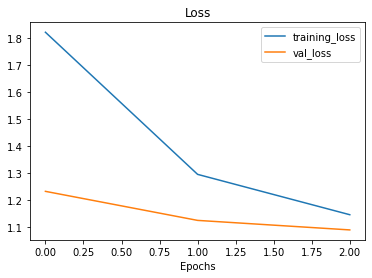

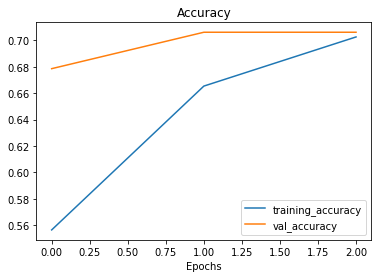

In [30]:
# Plot loss curves
plot_loss_curves(history_feature_extraction)

## Fine Tune our Model

In [32]:
# Unfreeze all of the layers in base model
base_model.trainable = True

In [34]:
# Create an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)

In [35]:
checkpoint_path_fine_tune = "model_checkpoint/fine_tune_cp_final.ckpt"
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_fine_tune,
                                                                monitor="val_loss",
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                verbose=1)

In [36]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [37]:
# Recompile the model with less learning rate this time
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [38]:
history_fine_tune = model.fit(train_data,
                              epochs=100,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history_feature_extraction.epoch[-1],
                              callbacks=[create_tensorboard_callback("training_logs","fine_tuning_model"),fine_tune_model_checkpoint,early_stopping,reduce_lr])

Saving TensorBoard log files to: training_logs/fine_tuning_model/20211029-103849
Epoch 3/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 1157s 475ms/step - loss: 0.9813 - accuracy: 0.7385 - val_loss: 0.8217 - val_accuracy: 0.7683

Epoch 00003: val_loss improved from inf to 0.82171, saving model to model_checkpoint/fine_tune_cp_final.ckpt
Epoch 4/100
2368/2368 [==============================] - 1098s 463ms/step - loss: 0.6115 - accuracy: 0.8326 - val_loss: 0.8044 - val_accuracy: 0.7794

Epoch 00004: val_loss improved from 0.82171 to 0.80442, saving model to model_checkpoint/fine_tune_cp_final.ckpt
Epoch 5/100
2368/2368 [==============================] - 1097s 462ms/step - loss: 0.3439 - accuracy: 0.9035 - val_loss: 0.8728 - val_accuracy: 0.7847

Epoch 00005: val_loss did not improve from 0.80442

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 6/100
2368/2368 [==============================] - 1112s 469ms/step - loss: 0.1008 - accuracy: 0.9745 - val_loss: 0.9490 - val_accuracy: 0.8011

Epoch 00006: val_loss did not improve from 0.80442

E

In [39]:
# Load the best weights
model.load_weights(checkpoint_path_fine_tune)

In [40]:
# Get the evaluation on full test data
results_fine_tune = model.evaluate(test_data, verbose=1)

790/790 [==============================] - 73s 92ms/step - loss: 0.8057 - accuracy: 0.7816


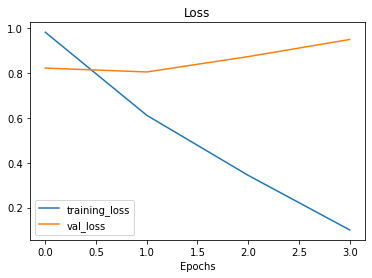

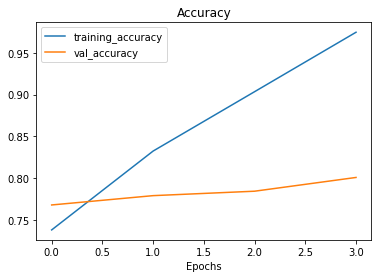

In [41]:
# Plotting Loss Curves of Fine Tuned Model
plot_loss_curves(history_fine_tune)

## Comparing Histories of the feature extraction and fine tune model

In [42]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

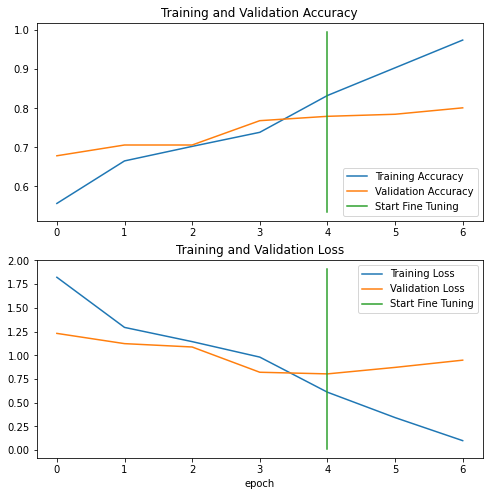

In [43]:
compare_historys(history_feature_extraction, history_fine_tune)

## Making Predictions from the model

In [44]:
# Getting prediction probabilities
prediction_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 67s 83ms/step


In [45]:
# Check first 5
prediction_probs[:5]

array([[2.66416202e-04, 6.97499956e-07, 8.68052780e-07, 2.76863616e-08,
        7.32512081e-06, 1.71289446e-06, 2.02984054e-07, 1.15900241e-06,
        7.89182144e-04, 1.28559877e-05, 2.57677129e-05, 2.10184381e-09,
        6.70979425e-05, 4.34912472e-05, 5.30788457e-05, 5.72542831e-08,
        6.61967206e-04, 1.48305087e-03, 9.47375178e-10, 1.43117711e-06,
        2.74709056e-08, 3.10257776e-04, 3.10257776e-04, 3.07196788e-05,
        8.81722542e-07, 8.68052780e-07, 1.27291526e-06, 4.73940745e-05,
        1.05528363e-06, 9.65471804e-01, 5.81906410e-04, 4.14248469e-04,
        3.96588824e-08, 9.32687483e-10, 2.98371975e-04, 1.42517180e-08,
        7.57355083e-05, 1.12977645e-07, 4.88693352e-09, 1.43937257e-07,
        7.76483304e-08, 8.52800000e-08, 1.40391465e-04, 9.62294133e-10,
        1.54097801e-08, 3.24561354e-03, 2.79035088e-08, 3.94924760e-10,
        2.46765865e-07, 3.88333101e-05, 3.67556652e-07, 2.92426243e-08,
        1.71908532e-08, 1.68684230e-04, 8.62594995e-10, 1.272915

We have all the predicted values of our model, now we need to unbatch our test data and get the true labels

In [46]:
# Get the true labels
true_labels = []
for images,labels in test_data.unbatch():
  true_labels.append(labels.numpy())

In [47]:
# Get the prediction classes
prediction_classes = prediction_probs.argmax(axis=1)

## Plot a confusion matrix

In [48]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

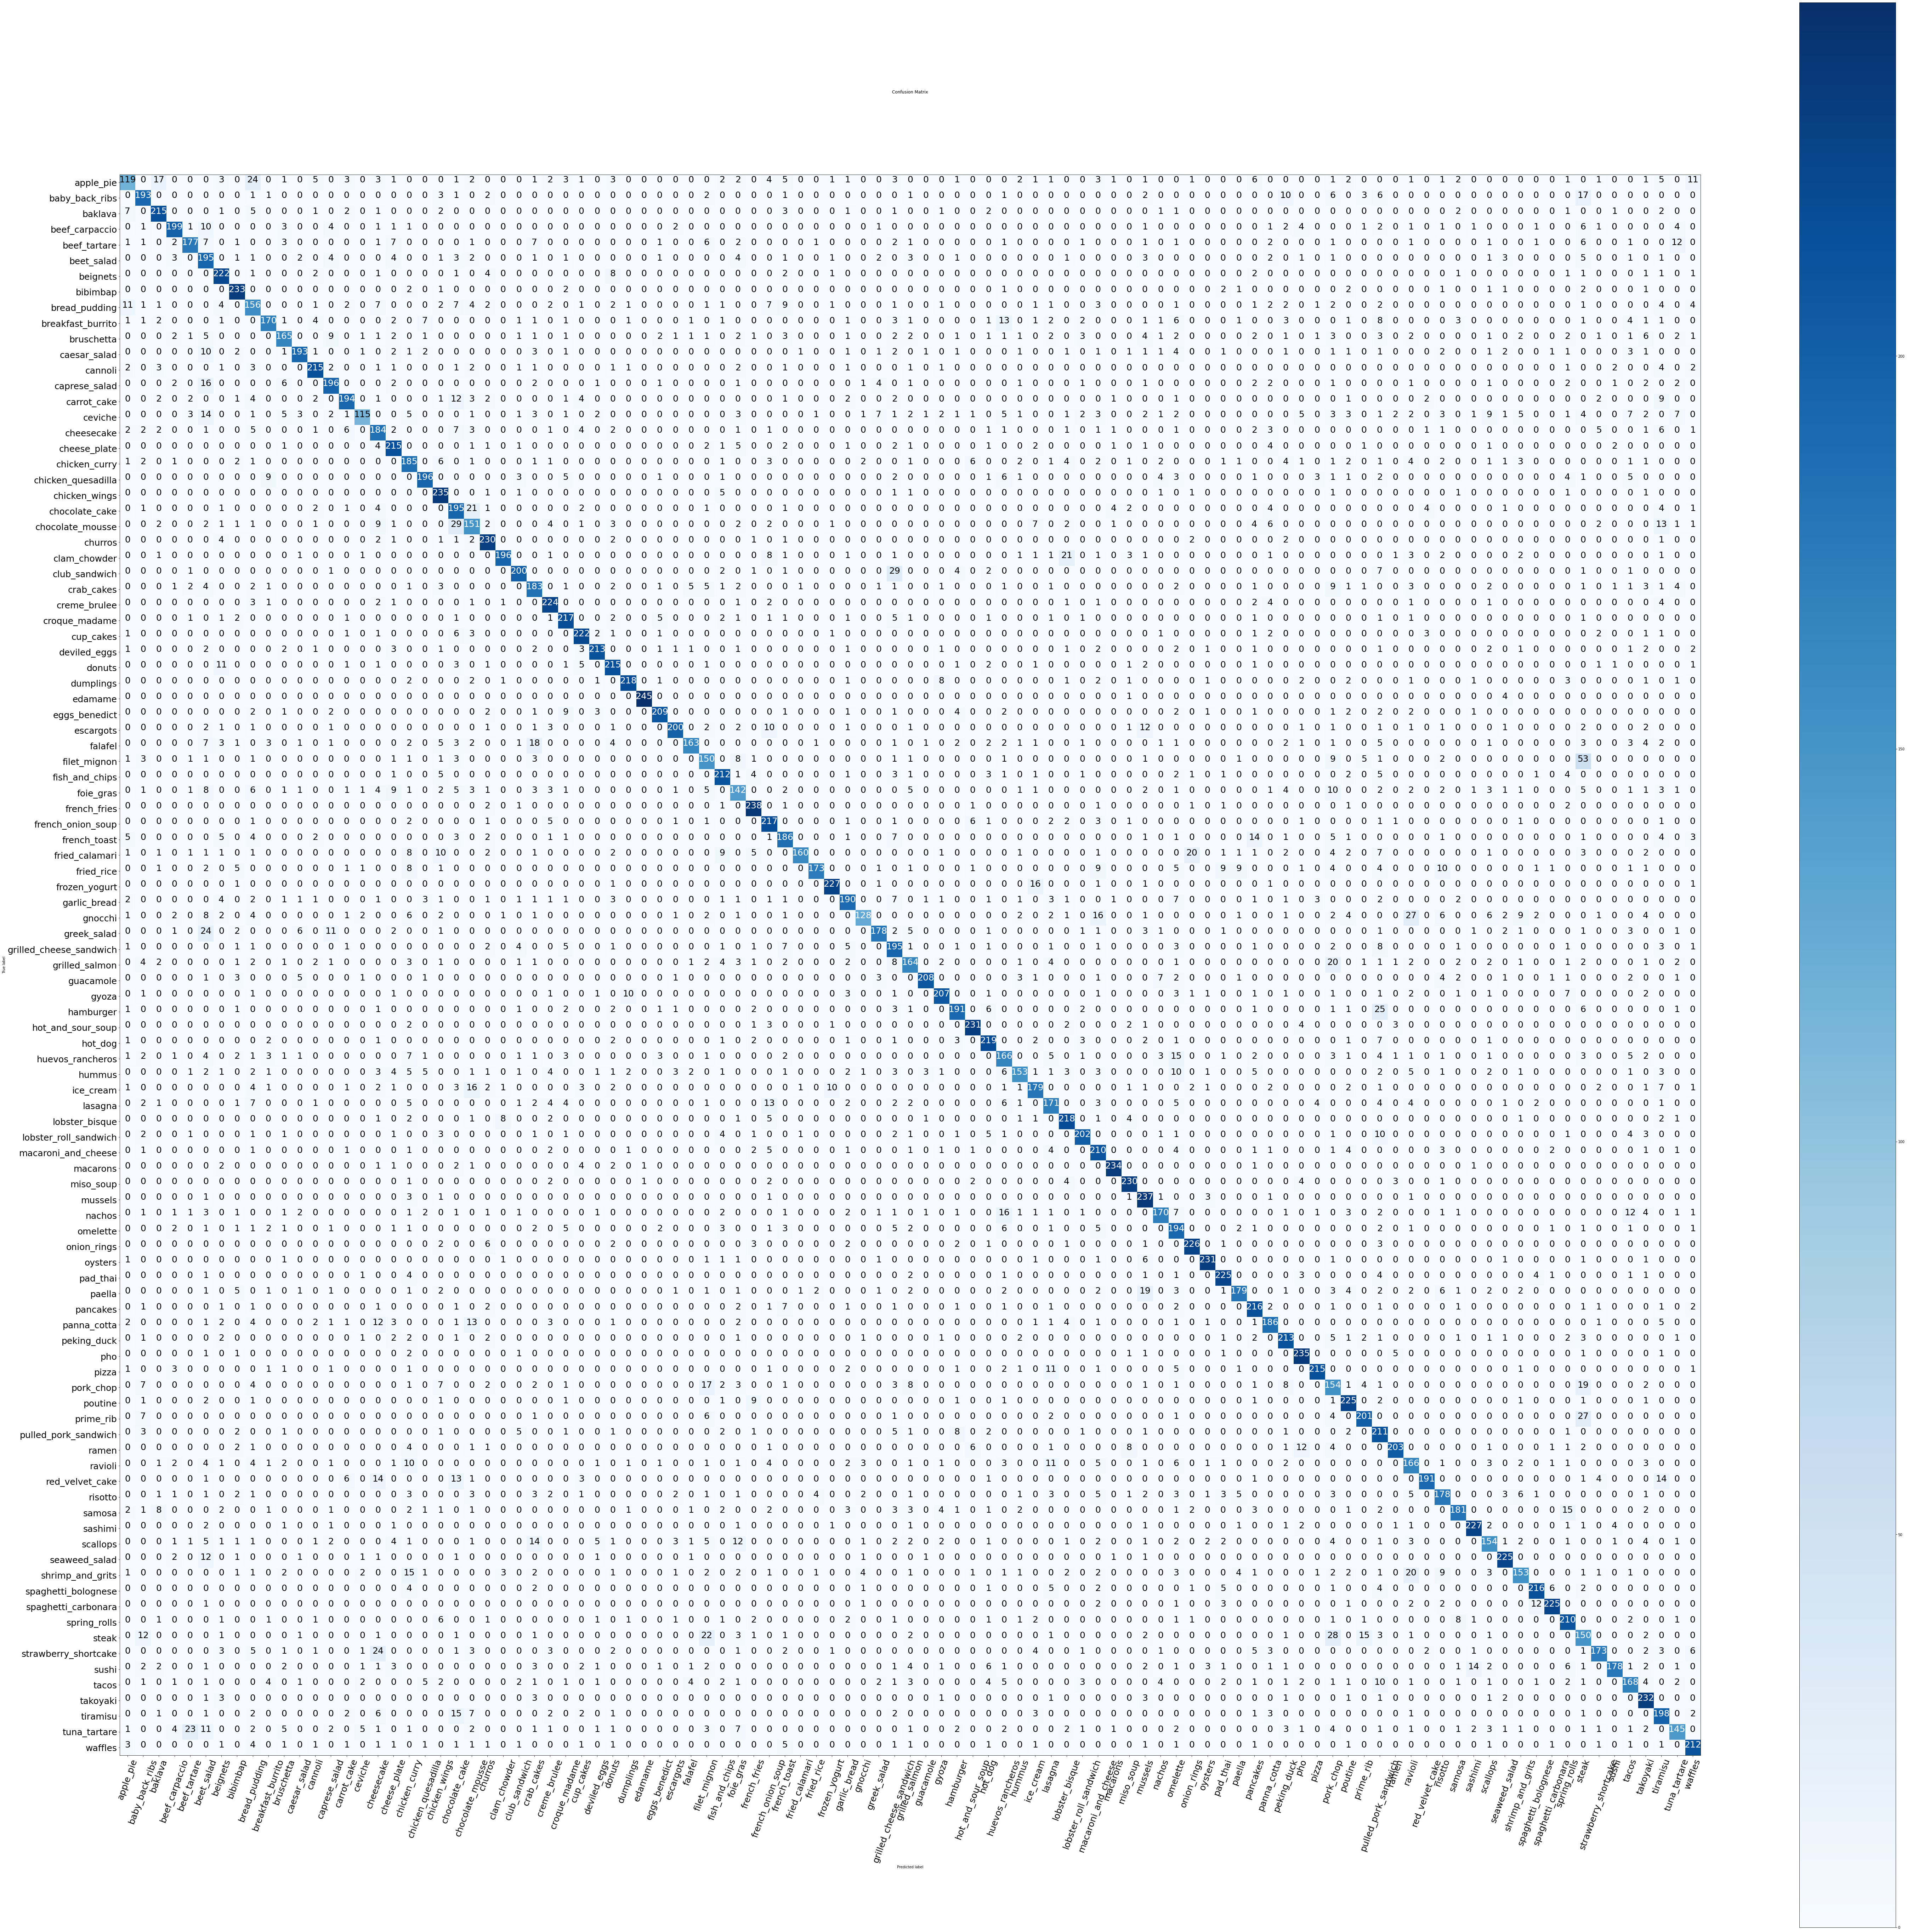

In [49]:
# Plot the confusion matrix
make_confusion_matrix(true_labels,
                      prediction_classes,
                      class_names,
                      (100,100),
                      25)

## Let's keep the evaluation going with a classficiation report

In [50]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,prediction_classes))

              precision    recall  f1-score   support

           0       0.69      0.48      0.56       250
           1       0.76      0.77      0.76       250
           2       0.81      0.86      0.84       250
           3       0.86      0.80      0.83       250
           4       0.81      0.71      0.76       250
           5       0.52      0.78      0.62       250
           6       0.77      0.89      0.83       250
           7       0.84      0.93      0.88       250
           8       0.55      0.62      0.59       250
           9       0.84      0.68      0.75       250
          10       0.77      0.66      0.71       250
          11       0.88      0.77      0.82       250
          12       0.87      0.86      0.86       250
          13       0.80      0.78      0.79       250
          14       0.85      0.78      0.81       250
          15       0.84      0.46      0.59       250
          16       0.61      0.74      0.67       250
          17       0.76    

In [51]:
# Get a dictionary/visualize our classfication report
classification_report_dic = classification_report(true_labels,prediction_classes,output_dict=True)
classification_report_dic

{'0': {'f1-score': 0.5639810426540285,
  'precision': 0.6918604651162791,
  'recall': 0.476,
  'support': 250},
 '1': {'f1-score': 0.7643564356435643,
  'precision': 0.7568627450980392,
  'recall': 0.772,
  'support': 250},
 '10': {'f1-score': 0.712742980561555,
  'precision': 0.7746478873239436,
  'recall': 0.66,
  'support': 250},
 '100': {'f1-score': 0.8379446640316205,
  'precision': 0.828125,
  'recall': 0.848,
  'support': 250},
 '11': {'f1-score': 0.821276595744681,
  'precision': 0.8772727272727273,
  'recall': 0.772,
  'support': 250},
 '12': {'f1-score': 0.8634538152610441,
  'precision': 0.8669354838709677,
  'recall': 0.86,
  'support': 250},
 '13': {'f1-score': 0.791919191919192,
  'precision': 0.8,
  'recall': 0.784,
  'support': 250},
 '14': {'f1-score': 0.8117154811715482,
  'precision': 0.8508771929824561,
  'recall': 0.776,
  'support': 250},
 '15': {'f1-score': 0.5943152454780362,
  'precision': 0.8394160583941606,
  'recall': 0.46,
  'support': 250},
 '16': {'f1-sco

###Let's plot all of our F1 scores

In [52]:
# Create an emtpy dictionary
class_f1_scores = {}
# Loop through classification report dict items
for key,value in classification_report_dic.items():
  if key == "accuracy": #stop when accuracy key comes 
    break 
  else:
    # Add class names and f1 scores to dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]
class_f1_scores

{'apple_pie': 0.5639810426540285,
 'baby_back_ribs': 0.7643564356435643,
 'baklava': 0.8365758754863815,
 'beef_carpaccio': 0.8274428274428274,
 'beef_tartare': 0.7564102564102564,
 'beet_salad': 0.6210191082802548,
 'beignets': 0.8268156424581006,
 'bibimbap': 0.8825757575757576,
 'bread_pudding': 0.5864661654135338,
 'breakfast_burrito': 0.750551876379691,
 'bruschetta': 0.712742980561555,
 'caesar_salad': 0.821276595744681,
 'cannoli': 0.8634538152610441,
 'caprese_salad': 0.791919191919192,
 'carrot_cake': 0.8117154811715482,
 'ceviche': 0.5943152454780362,
 'cheese_plate': 0.8082706766917293,
 'cheesecake': 0.6690909090909091,
 'chicken_curry': 0.6642728904847397,
 'chicken_quesadilla': 0.8235294117647058,
 'chicken_wings': 0.8377896613190731,
 'chocolate_cake': 0.6806282722513088,
 'chocolate_mousse': 0.5956607495069034,
 'churros': 0.8695652173913044,
 'clam_chowder': 0.8484848484848485,
 'club_sandwich': 0.8316008316008316,
 'crab_cakes': 0.6971428571428572,
 'creme_brulee': 0.

In [53]:
# Turn f1 scores into a dataframe to visualize 
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.985915
63,macarons,0.943548
69,oysters,0.927711
91,spaghetti_carbonara,0.916497
45,frozen_yogurt,0.915323
...,...,...
15,ceviche,0.594315
8,bread_pudding,0.586466
0,apple_pie,0.563981
77,pork_chop,0.546099


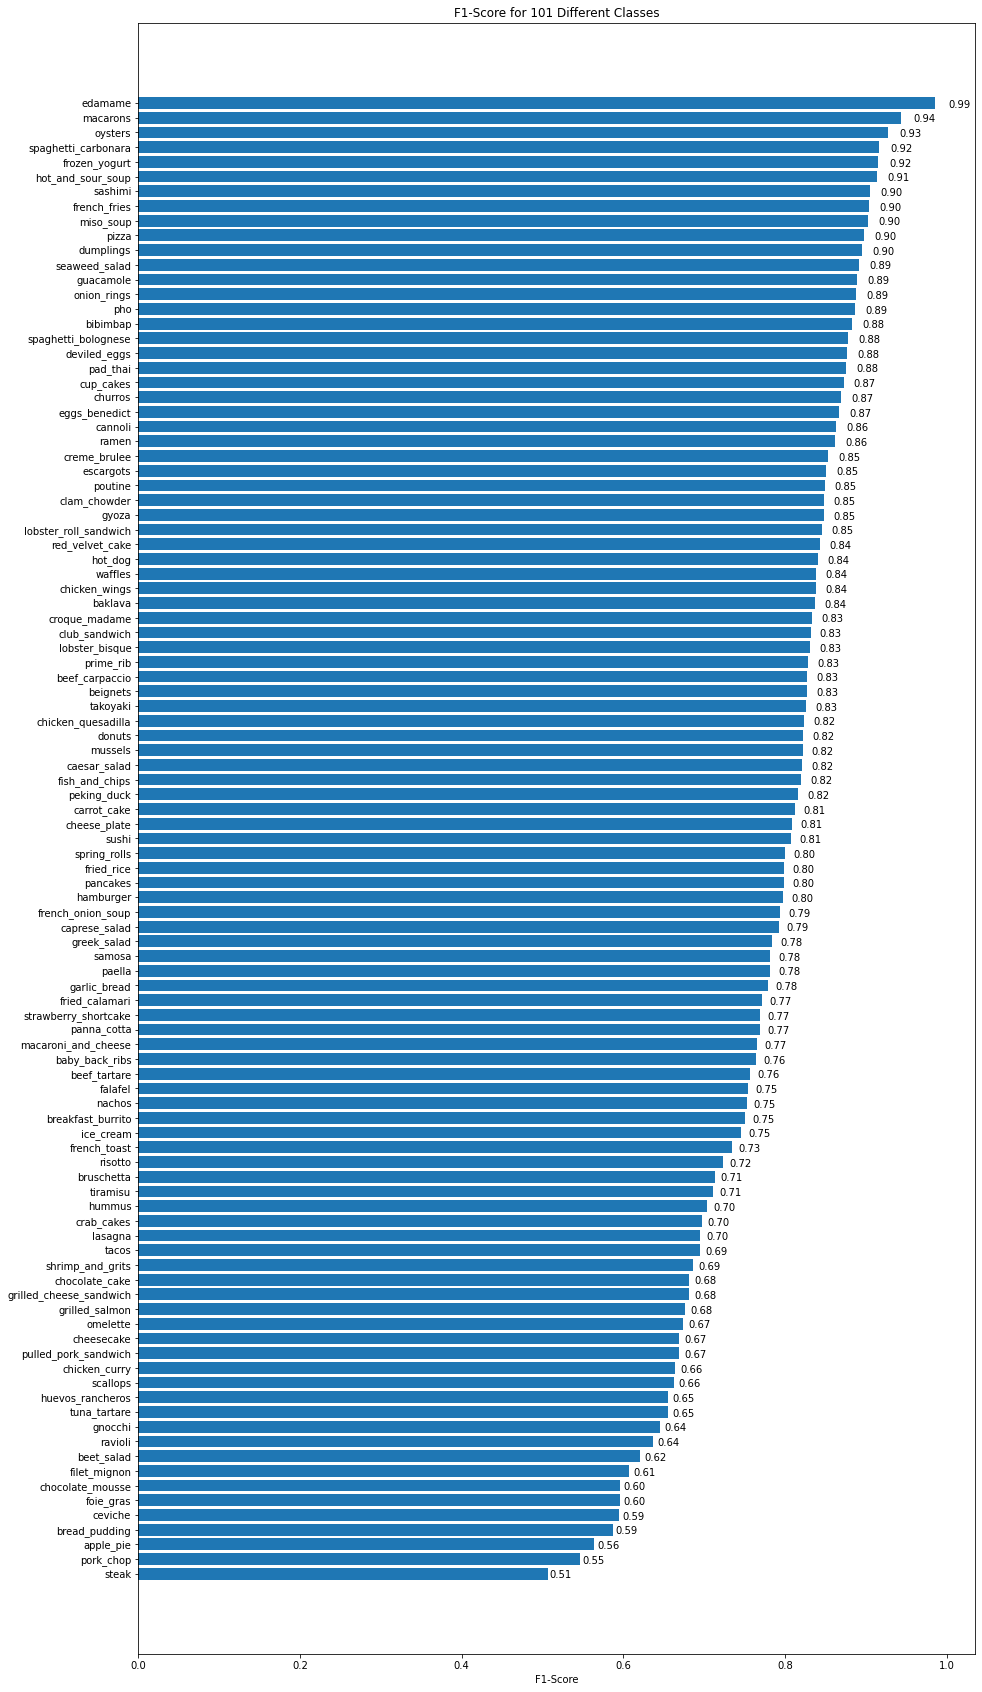

In [54]:
# Plot as a bar graph
fig,ax = plt.subplots(figsize=(15,30)) 
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"])
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Score for 101 Different Classes")
ax.invert_yaxis();

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/0.95,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images

In [55]:
# Preprocessing an image before testing
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape,img_shape,color_channels)
  """
  # Read an image
  img = tf.io.read_file(filename)
  # Decode the read file into tensor
  img = tf.image.decode_image(img, channels=3) # added channels param if it's a png file because png has 4 color channels
  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])
  # Rescale the image and get all values between 0 and 1
  if scale:
    img = img / 255.
    return img
  else:
    return img

## Testing on custom images

In [62]:
# Get the custom food images filepaths
import os
custom_images_filepaths = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_images_filepaths

['custom_food_images/veg-fried-rice.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/nachos.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/spaghetti-carbonara.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza.jpeg',
 'custom_food_images/lasagna.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hot-dog.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/.ipynb_checkpoints']

FailedPreconditionError: ignored

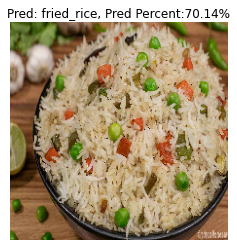

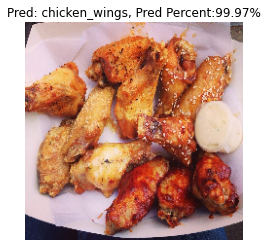

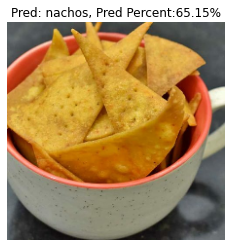

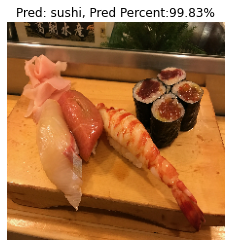

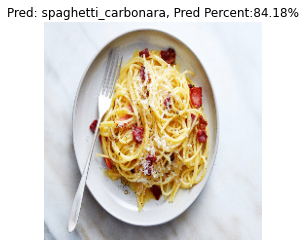

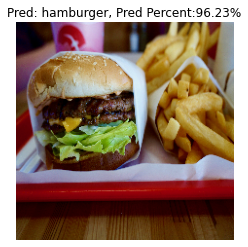

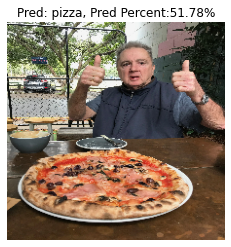

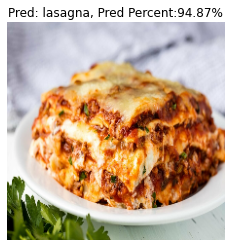

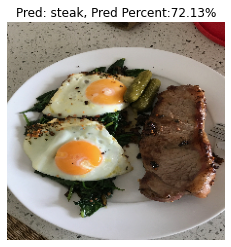

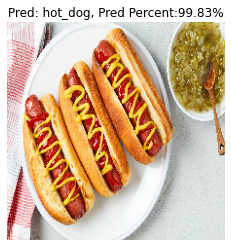

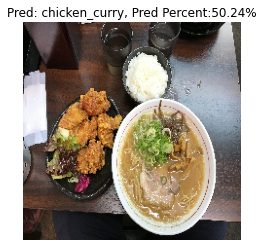

In [64]:
# Make predictions and plot images
for img in custom_images_filepaths:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[tf.argmax(pred_prob[0])]
  # Plot the images
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, Pred Percent:{pred_prob.max()*100:.2f}%")
  plt.axis(False);

## Saving and loading trained model

In [65]:
model.save("/content/drive/MyDrive/food-vision/food-vision-fine-tune-model-101-classes")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/food-vision/food-vision-fine-tune-model-101-classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/food-vision/food-vision-fine-tune-model-101-classes/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Accuracy of 78.16% was achieved by our food-vision model beating the 77.4% accuracy of the https://arxiv.org/abs/1606.05675 Paper 